# Exploratory Data Analysis (EDA)

## 1. Preliminary Steps

### Load Data
This section involves importing the necessary Python libraries and loading our five core datasets to analyze the relationship between health expenditure, lifestyle factors, and obesity:
1.  **Health Expenditure:** Government spending on health as a share of GDP.
2.  **Obesity Rates:** The share of the adult population defined as obese.
3.  **Internet Usage:** A proxy for sedentary "digital" lifestyles.
4.  **Urbanization:** The percentage of the population living in urban areas.
5.  **GDP Per Capita:** A measure of a country's economic output per person.

In [8]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the visual style for graphs
sns.set(style="whitegrid")

# Load the datasets
# Note: 'Health' uses commas (,), while others use semicolons (;)
df_health = pd.read_csv('public-healthcare-spending-share-gdp.csv', sep=',')
df_obesity = pd.read_csv('share-of-adults-defined-as-obese.csv', sep=';')
df_internet = pd.read_csv('share-of-individuals-using-the-internet.csv', sep=';')
df_urban = pd.read_csv('share-of-population-urban.csv', sep=';')
df_gdp = pd.read_csv('gdp-per-capita-worldbank.csv', sep=';')


### Data Cleaning and Merging

In this section, we preprocess the datasets to ensure they are ready for analysis.
1.  **Renaming Columns:** We standardize column names (e.g., shortening long World Bank descriptions to simple terms like `Health_Expenditure`) to make the code readable.
2.  **Data Type Conversion:** We ensure the `Year` column is numeric across all files to prevent errors during merging.
3.  **Merging:** We perform an **Inner Join** on `Entity` (Country) and `Year`. This creates a unified dataset containing only the records where we have complete data for all variables.

In [10]:
# 1. Standardize Column Names
df_health = df_health.rename(columns={'Domestic general government health expenditure (% of GDP)': 'Health_Expenditure'})
df_obesity.columns = ['Entity', 'Code', 'Year', 'Obesity_Rate']
df_internet.columns = ['Entity', 'Code', 'Year', 'Internet_Usage']
df_urban = df_urban.rename(columns={'Urban population (% of total population)': 'Urban_Rate'})
# GDP file often has extra columns; we select the first 4 and rename
df_gdp = df_gdp.iloc[:, :4] 
df_gdp.columns = ['Entity', 'Code', 'Year', 'GDP_Per_Capita']

# 2. Clean 'Year' Column (Convert to numeric and drop bad rows)
for df in [df_health, df_obesity, df_internet, df_urban, df_gdp]:
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df.dropna(subset=['Year'], inplace=True)
    df['Year'] = df['Year'].astype(int)

# 3. Merge Datasets (Inner Join on Entity and Year)
df_merged = pd.merge(df_obesity[['Entity', 'Year', 'Obesity_Rate']], 
                     df_health[['Entity', 'Year', 'Health_Expenditure']], 
                     on=['Entity', 'Year'], how='inner')

df_merged = pd.merge(df_merged, df_internet[['Entity', 'Year', 'Internet_Usage']], 
                     on=['Entity', 'Year'], how='inner')

df_merged = pd.merge(df_merged, df_urban[['Entity', 'Year', 'Urban_Rate']], 
                     on=['Entity', 'Year'], how='inner')

df_merged = pd.merge(df_merged, df_gdp[['Entity', 'Year', 'GDP_Per_Capita']], 
                     on=['Entity', 'Year'], how='inner')


## 2. Dataset Overview

Now that the data is merged, we inspect its structure to verify data quality.
- **Shape:** Checks the total number of data points (rows and columns).
- **Head:** Displays the first few rows to visually confirm the merge.
- **Info:** Verifies data types and checks for any remaining null values.

In [9]:
# Check dimensions
print(f"Dataset Shape: {df_merged.shape}")

# Display first 5 rows
print("\nFirst 5 rows of the merged dataset:")
display(df_merged.head())

# Check data types
print("\nData Info:")
df_merged.info()

Dataset Shape: (4107, 7)

First 5 rows of the merged dataset:


,Entity,Year,Obesity_Rate,Health_Expenditure,Internet_Usage,Urban_Rate,GDP_Per_Capita
0,Afghanistan,2002,4.33978,0.084181,0.004561,22.261,1774.3087
1,Afghanistan,2003,4.69862,0.650963,0.087891,22.353,1815.9282
2,Afghanistan,2004,5.08183,0.542926,0.105809,22.500,1776.9182
3,Afghanistan,2005,5.48633,0.529184,1.224150,22.703,1908.1147
4,Afghanistan,2006,5.91647,0.497840,2.107120,22.907,1929.7239



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4107 entries, 0 to 4106
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Entity              4107 non-null   object 
 1   Year                4107 non-null   int32  
 2   Obesity_Rate        4107 non-null   float64
 3   Health_Expenditure  4107 non-null   float64
 4   Internet_Usage      4107 non-null   float64
 5   Urban_Rate          4107 non-null   float64
 6   GDP_Per_Capita      4107 non-null   float64
dtypes: float64(5), int32(1), object(1)
memory usage: 208.7+ KB


## 3. Summary Statistics

Here we examine the statistical properties of our variables (Mean, Standard Deviation, Min/Max).
- **Key Observation:** We want to check if the data ranges make sense (e.g., Obesity Rate should be between 0 and 100).
- **Count:** Verifies that we have consistent data coverage across all years.

In [11]:
# Generate descriptive statistics
print("Summary Statistics:")
display(df_merged.describe())

Summary Statistics:


,Year,Obesity_Rate,Health_Expenditure,Internet_Usage,Urban_Rate,GDP_Per_Capita
count,4107.000000,4107.000000,4107.000000,4107.000000,4107.000000,4107.000000
mean,2011.050889,18.424823,3.275499,36.880464,56.377400,21580.346714
std,6.608906,11.586940,2.298393,31.292948,22.650103,23352.011778
min,2000.000000,0.280140,0.062210,0.000000,8.246000,711.976400
25%,2005.000000,8.761240,1.534732,6.876700,37.653500,4688.853000
50%,2011.000000,18.206240,2.729109,29.643100,56.685000,13249.065000
75%,2017.000000,25.425870,4.572787,65.477400,74.613500,30661.508500
max,2022.000000,70.182860,22.254263,100.000000,100.000000,145591.020000


### VISUALIZATION

## 4. Global Trends (2000-2016) and Scatter P

Before testing correlations, we visualize the global averages over time.
- **Red Line:** Obesity Rate (%)
- **Blue Line:** Health Expenditure (% of GDP)

**Goal:** Determine if these two metrics are moving in the same direction globally.

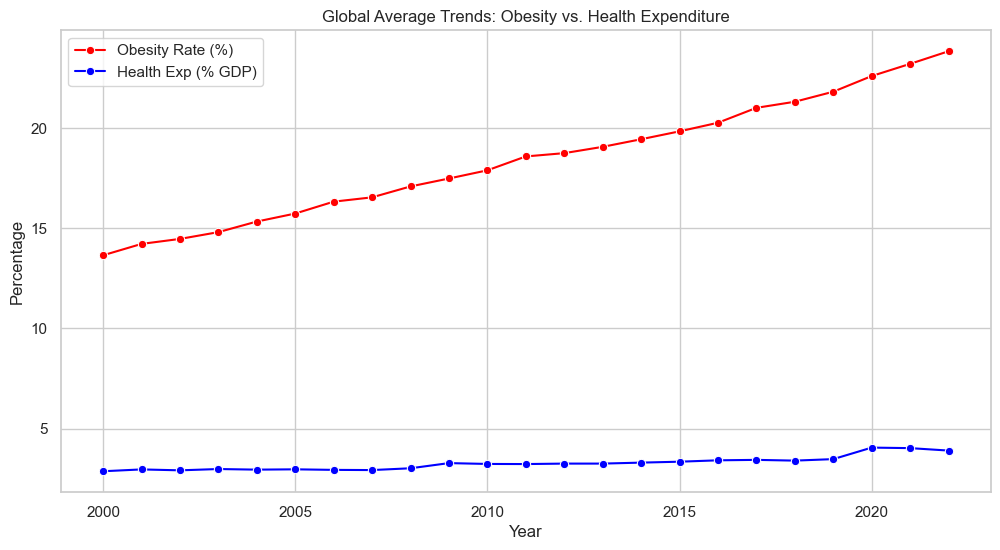

In [12]:
# Group by Year to get the global average for each metric
annual_trends = df_merged.groupby('Year')[['Obesity_Rate', 'Health_Expenditure']].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=annual_trends, x='Year', y='Obesity_Rate', label='Obesity Rate (%)', color='red', marker='o')
sns.lineplot(data=annual_trends, x='Year', y='Health_Expenditure', label='Health Exp (% GDP)', color='blue', marker='o')

plt.title('Global Average Trends: Obesity vs. Health Expenditure')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

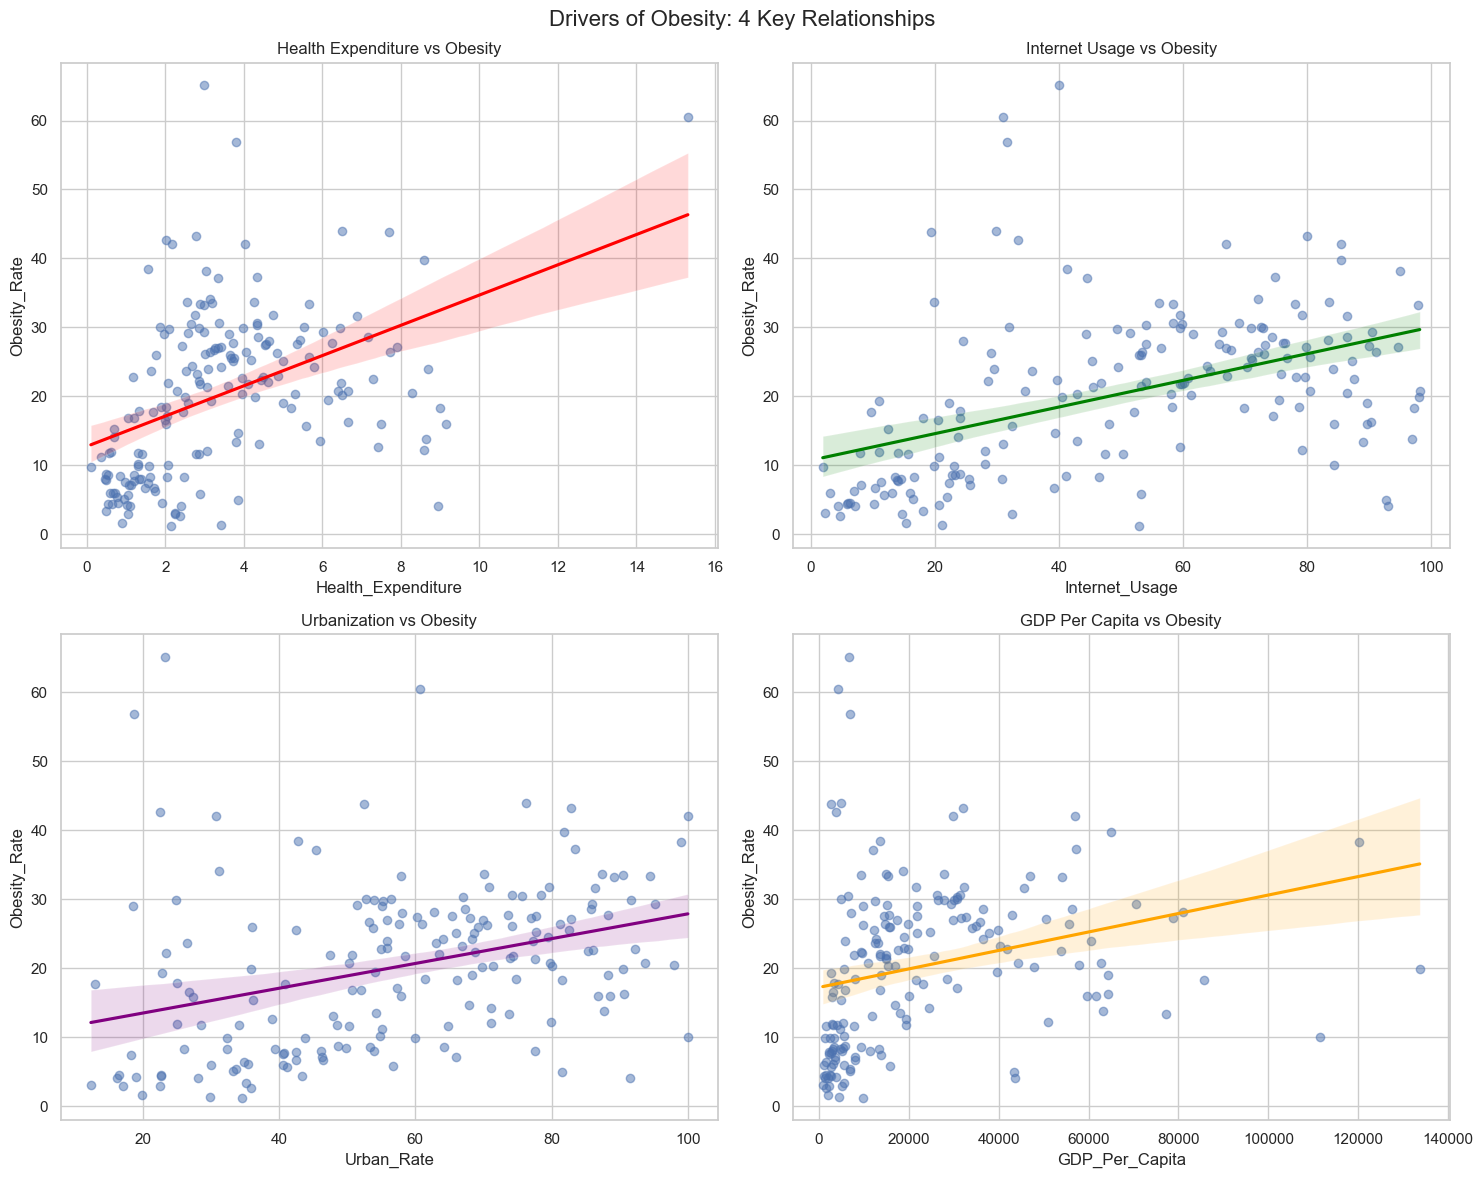

In [14]:
# subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Drivers of Obesity: 4 Key Relationships', fontsize=16)

# Plot 1: Health Expenditure 
sns.regplot(ax=axes[0, 0], data=df_2016, x='Health_Expenditure', y='Obesity_Rate', 
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 0].set_title('Health Expenditure vs Obesity')

# Plot 2: Internet Usage 
sns.regplot(ax=axes[0, 1], data=df_2016, x='Internet_Usage', y='Obesity_Rate', 
            scatter_kws={'alpha':0.5}, line_kws={'color':'green'})
axes[0, 1].set_title('Internet Usage vs Obesity')

# Plot 3: Urbanization 
sns.regplot(ax=axes[1, 0], data=df_2016, x='Urban_Rate', y='Obesity_Rate', 
            scatter_kws={'alpha':0.5}, line_kws={'color':'purple'})
axes[1, 0].set_title('Urbanization vs Obesity')

# Plot 4: GDP Per Capita 
sns.regplot(ax=axes[1, 1], data=df_2016, x='GDP_Per_Capita', y='Obesity_Rate', 
            scatter_kws={'alpha':0.5}, line_kws={'color':'orange'})
axes[1, 1].set_title('GDP Per Capita vs Obesity')

plt.tight_layout()
plt.show()

## 5. Correlation Analysis
This heatmap summarizes the linear relationships between all our variables.
- **Values close to +1:** Strong positive relationship (Both go up).
- **Values close to -1:** Strong negative relationship (One goes up, one goes down).
- **Values near 0:** No relationship.

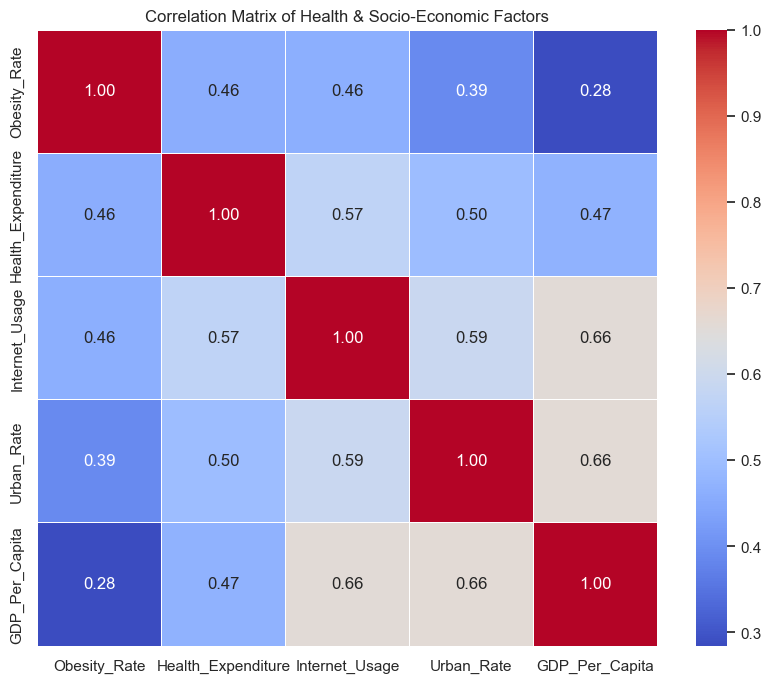

In [15]:
# Correlation matrix
corr_matrix = df_merged[['Obesity_Rate', 'Health_Expenditure', 'Internet_Usage', 'Urban_Rate', 'GDP_Per_Capita']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Health & Socio-Economic Factors')
plt.show()